#  <center> Майнор "Прикладные задачи анализа данных"
##  <center> Домашнее задание 2 "Предсказание цены акции по экономическим новостям"

**Задача**: предсказать рост цены акции компании Газпром по новостям о компании.

####  <center> Содержание: 
1. [Предварительная обработка текстов и эксплоративный анализ](#)
2. [Baseline алгоритм](#)
3. [Творческая часть](#)
* [Выводы](#-Выводы)

<!--
Требования к отчету:
* Краткую постановку задачи и формулировку задания.
* Описание минимума необходимой теории и/или описание используемых инструментов.
* Комментарии к проделанной работе.
* Выводы и ответы на вопросы.
* Ссылки на источники!
* Воспроизводимый код! Явное указание дополнительных действий для запуска.
-->

Выполнили студенты ИАД-3:
* Пчелкин Дмитрий
* Сергеев Сергей
* Ведмидь Евгений

Входные данные:
* `texts.csv` - новости о компании "Газпром", начиная с 2010 года
* `gazprom_prices.csv` - стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * `Open` - цена открытия
    * `ClosingPrice` - цена закрытия
    * `DailyHigh` - максимальная цена за день
    * `DailyLow` - минимальная цена за день 
    * `VolumePcs` - объем бумаг

In [1]:
# Logging is used due to output's verbosity control (by verbosity levels).
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
# There is no necessity to run this cell! It's only useful for debugging.
# This commands will display all cell's outputs instead of only last one.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Установка зависимостей. Нет необходимости запускать, если указанные модули уже установленны в окружении.

```python
!pip3 install -U --no-cache matplotlib pandas numpy tqdm pymorphy2
```

*Запуск инструкций коммандной строки, ровно как и некоторые другие возможности `jupyter`, заимствованны [отсюда (рус.)](https://gitlab.com/hell03end/materials/blob/master/CheatSheet4Jupyter.ipynb).*

In [3]:
#!pip install watermark
%load_ext watermark

In [4]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn,gensim,seaborn,pymystem3,nltk,pymorphy2 -g

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


CPython 3.5.2
IPython 6.2.1

numpy 1.13.3
scipy 1.0.0
pandas 0.22.0
matplotlib 2.1.2
sklearn 0.19.1
gensim 3.3.0
seaborn 0.8.1
pymystem3 0.1.9
nltk 3.2.5
pymorphy2 0.8

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.119-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   : 1217de66db28dd41a6f6d78ce85ba4827af94dec


#### Загрузка данных

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (9,6)

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
corp = pd.read_csv('texts.csv', index_col=0, parse_dates=True)
corp.info()
corp.text = corp.text.apply(str.strip)
corp.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1203 entries, 2017-09-11 to 2010-04-01
Data columns (total 1 columns):
text    1203 non-null object
dtypes: object(1)
memory usage: 18.8+ KB


text
date                                                         
2017-09-11  Компания рассчитывает на решение по газовому с...
2017-08-11  Как и предполагал “Ъ”, «Газпром», воспользовав...
2017-01-11  Новая редакция американских санкций ставит под...
2017-10-30  Как стало известно “Ъ”, известный на рынке рис...
2017-10-23  НОВАТЭК, который через пять лет собирается зап...

In [8]:
df = pd.read_csv('gazprom_prices.csv', sep=';', index_col=0, parse_dates=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1988 entries, 2017-08-12 to 2010-11-01
Data columns (total 5 columns):
Open            1964 non-null object
ClosingPrice    1988 non-null object
DailyHigh       1986 non-null object
DailyLow        1986 non-null object
VolumePcs       1988 non-null int64
dtypes: int64(1), object(4)
memory usage: 93.2+ KB


Open ClosingPrice  DailyHigh   DailyLow  VolumePcs
Date                                                               
2017-08-12  133,43000    132,60000  133,90000  132,00000   16037970
2017-07-12  133,70000    133,02000  133,87000  132,81000   18198430
2017-06-12  133,33000    134,00000  134,29000  132,91000   14641730
2017-05-12  133,48000    133,65000  133,99000  132,78000   12684800
2017-04-12  133,01000    133,77000  134,00000  131,93000   17818980

Пропуски в данных отсутствуют, однако размер данных превышает число документов.

In [9]:
def convert_to_float(df: object, rows: list) -> object:
    for row in rows:
        df[row] = df[row].apply(lambda x: str(x).replace(",", ".")).astype(np.float)
    return df

In [10]:
df = convert_to_float(df, df.columns.values[:-1])
df.VolumePcs = df.VolumePcs.astype(np.int)
df.info()

df.rename({"Open": "OpenPrice"}, axis=1, inplace=True)
df.OpenPrice.fillna(df.OpenPrice.mean(), inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1988 entries, 2017-08-12 to 2010-11-01
Data columns (total 5 columns):
Open            1964 non-null float64
ClosingPrice    1988 non-null float64
DailyHigh       1986 non-null float64
DailyLow        1986 non-null float64
VolumePcs       1988 non-null int64
dtypes: float64(4), int64(1)
memory usage: 93.2 KB


In [11]:
df_corp = df.join(corp).sort_index()
df_corp['Len'] = df_corp.text.apply(lambda x: 0 if x is np.NaN else len(x.strip()))
df_corp['DayDiff'] = df_corp.ClosingPrice - df_corp.OpenPrice
df_corp['MinMaxDiff'] = df_corp.DailyHigh - df_corp.DailyLow
df_corp.head()

OpenPrice  ClosingPrice  DailyHigh  DailyLow  VolumePcs  \
Date                                                                  
2010-01-02     184.74        189.85     190.40    183.50   76298175   
2010-01-03     168.70        168.20     170.71    166.33   58570262   
2010-01-04     172.49        175.00     176.14    172.33   94994135   
2010-01-06     158.20        159.26     160.31    154.39   67031024   
2010-01-07     147.00        143.20     147.77    143.04   50067990   

                                                         text  Len  DayDiff  \
Date                                                                          
2010-01-02  "Газпром" не исключает в 2010 г. выпуска облиг...  255     5.11   
2010-01-03                                                NaN    0    -0.50   
2010-01-04                                                NaN    0     2.51   
2010-01-06                                                NaN    0     1.06   
2010-01-07                                                NaN    0    -3.80   

            MinMaxDiff  
Date                    
2010-01-02        6.90  
2010-01-03        4.38  
2010-01-04        3.81  
2010-01-06        5.92  
2010-01-07        4.73

In [12]:
raw_texts = corp.copy().values.ravel()
raw_texts[0]

'Компания рассчитывает на решение по газовому спору с Украиной до конца декабря «Газпром» ожидает решения Стокгольмского арбитража по транзитному спору с украинским «Нафтогазом» не позднее февраля 2018 года, хотя раньше компания прогнозировала, что это произойдет до 30 ноября. Решение по взаимным искам об условиях поставок газа на Украину, по мнению монополии, суд может принять на месяц раньше — до декабря 2017 года.'

Посмотрим на распределение длин текстов.

count    1159.000000
mean      770.774806
std       544.756492
min        84.000000
50%       582.000000
max      4110.000000
Name: Len, dtype: float64

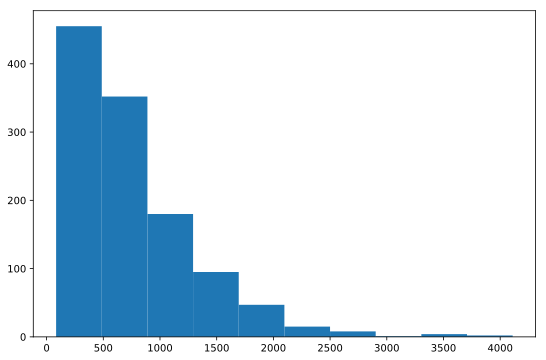

In [13]:
_ = plt.hist(df_corp.Len[df_corp.Len > 0])
df_corp.Len[df_corp.Len > 0].describe([])

Поскольку в данных имеются пропуски, можно попробовать построить целевую переменную следующим образом:
$$Diff = ClosePrice_i - OpenPrice_j, \text{где } j - \text{первый день отсутствия новостей},$$
\- то есть будет учтена разница в цене за весь период, а не отдельный день.

```python
# example of realization
df_corp['Diff'] = np.zeros_like(df_corp.OpenPrice.values)
df_shifted = df_corp.shift()
sidx = sorted(df_corp.index)
open_price = df_corp.loc[sidx[0]].OpenPrice
for t in sidx:
    if df_corp.loc[t].text is not np.NaN:
        df_corp.Diff[t] = df_corp.ClosingPrice.loc[t] - open_price
        open_price = df_shifted.OpenPrice.loc[t]
```

## Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия? **[Нет]**
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени **[Нет]**.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * **"турецкий поток"**?
* Кого упоминают чаще:
    * **Алексея Миллера**
    * Владимира Путина?
* О каких санкциях пишут в статьях? **[Чаще всего о связанных с Украиной]**

In [14]:
y = (df_corp.dropna().DayDiff >= 0).values.reshape(-1, 1)
y_reg = df_corp.dropna().DayDiff.values.reshape(-1, 1)
X = df_corp.dropna().drop(["DayDiff"], axis=1)

X.shape, y.shape

((1156, 8), (1156, 1))

In [15]:
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from tqdm import tqdm_notebook
from collections import Counter
import string
import nltk
import re

morph = MorphAnalyzer()
mystem = Mystem()

INFO:pymorphy2.opencorpora_dict.wrapper:Loading dictionaries from /usr/local/lib/python3.5/dist-packages/pymorphy2_dicts/data
INFO:pymorphy2.opencorpora_dict.wrapper:format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168


In [16]:
special_w = [
    'это', 'наш', 'т', 'д', 'этот', 'который', 'свой', 'наш', 'мой', 'твой', 'еще',
    'тот', 'делать', 'друг', 'сделать', 'любой', 'каждый', 'самый', 'хотеть', 'мочь', 'ваш', 
    'сей', 'весь', 'очень', 'день', 'год', 'м', 'ч', 'руб', 'л', 'например', 'становиться', 
    'январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 
    'октябрь', 'ноябрь', 'декабрь'
]
specific_w = ['газпром', 'оао',  'компания', 'млн', 'млрд']

stop_w = stopwords.words("russian") + stopwords.words('english')

def clear(texts: str, pattern: str=r"[^ a-zа-я-]") -> object:
    """ Remove special symbols from text """
    symb_pattern = re.compile(pattern)
    for text in texts:
        yield symb_pattern.sub(r' ', text.strip().lower())
    

def tokenize(texts: str, ignore: list=stop_w + special_w + specific_w) -> object:
    """ Remove stopwords, split to tokens, lemmatize, to lower """
    
    def _filter(token: str) -> bool:
        """ remove empty strings, punctuation and stopwords """
        t = token.strip()
        return len(t) > 2 and t not in ignore and t not in string.punctuation
    
    for text in texts:
        # nltk.word_tokenize can be used instead of mystem.lemmatize to produce simple tokens
        yield list(filter(_filter, mystem.lemmatize(text)))

In [17]:
X['ClearText'] = np.array(list(clear(X.text)))
tokens = np.array(list(tokenize(X.ClearText)))
X.ClearText[0]

' газпром  не исключает в      г  выпуска облигаций примерно на половину от общего объема заимствований  планирующихся в текущем году  сообщил на телефонной конференции в понедельник начальник управления по работе на финансовых рынках холдинга петр бакаев '

In [18]:
bigrams = np.array([list(nltk.bigrams(t)) for t in tokens])
bigrams[0][:10]

[('исключать', 'выпуск'),
 ('выпуск', 'облигация'),
 ('облигация', 'примерно'),
 ('примерно', 'половина'),
 ('половина', 'общий'),
 ('общий', 'объем'),
 ('объем', 'заимствование'),
 ('заимствование', 'планироваться'),
 ('планироваться', 'текущий'),
 ('текущий', 'сообщать')]

In [19]:
X['Tokens'] = np.array([" ".join(text) for text in tokens])
X.Tokens[0]

'исключать выпуск облигация примерно половина общий объем заимствование планироваться текущий сообщать телефонный конференция понедельник начальник управление работа финансовый рынок холдинг петр бакаев'

In [20]:
# frequencies of unique tokens
text_tokens_freq = np.array([Counter(t) for t in tokens])

In [21]:
nouns = []
for text in X.Tokens:
    words = []
    for word in text.split():
        p = morph.parse(word)
        if p and p[0].tag.POS == "NOUN":
            words.append(word)
    nouns.append(" ".join(words))
X['Nouns'] = np.array(nouns)

Посмотрим на корреляцию признаков.

Из графика видно, что длина декста не коррелирует ни с одним другим признаком в наборе данных (в т. ч. с ценой закрытия).

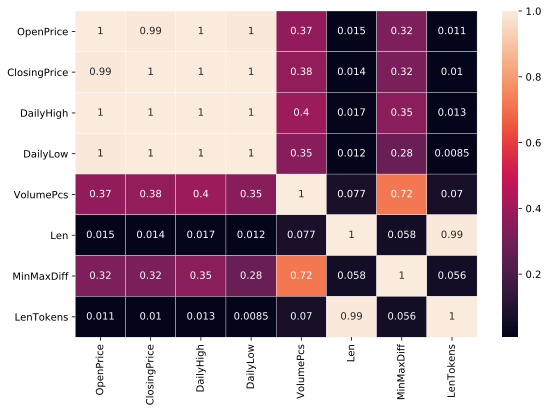

In [22]:
X['LenTokens'] = [len(t) for t in tokens]
_ = sns.heatmap(X.corr(), annot=True, linewidths=.3)

#### Изучение частот слов.

In [23]:
# list of all bigrams in corpus
common_bigrams = []
for b in bigrams:
    common_bigrams += b

bigr_freq = nltk.FreqDist(common_bigrams)
bigr_freq.most_common(10)

[(('поставка', 'газ'), 181),
 (('российский', 'газ'), 135),
 (('совет', 'директор'), 123),
 (('алексей', 'миллер'), 122),
 (('говориться', 'сообщение'), 119),
 (('цена', 'газ'), 100),
 (('чистый', 'прибыль'), 95),
 (('российский', 'газовый'), 86),
 (('нафтогаз', 'украина'), 85),
 (('председатель', 'правление'), 85)]

In [24]:
# list of all tokens in corpus
common_tokens = []
for t in tokens:
    common_tokens += t

tokens_freq = nltk.FreqDist(common_tokens)
tokens_freq.most_common(10)

[('газ', 1301),
 ('нефть', 819),
 ('российский', 670),
 ('сообщать', 564),
 ('проект', 517),
 ('поставка', 451),
 ('цена', 433),
 ('рынок', 361),
 ('монополия', 346),
 ('украина', 338)]

Словосочетание "`турецкий поток`" встречается чаще, чем "`северный поток`". Слова "`северный`" и "`турецкий`" также употребляются без слова "поток" с таким же отношением: $freq("турецкий") > freq("северный")$.

In [25]:
print("Count 'северный поток':", bigr_freq[("северный", "поток")])
print("Count 'турецкий поток':", bigr_freq[('турецкий', 'поток')])

print("Count 'северный':", np.sum([ttf['северный'] for ttf in text_tokens_freq]))
print("Count 'турецкий':", np.sum([ttf['турецкий'] for ttf in text_tokens_freq]))

Count 'северный поток': 15
Count 'турецкий поток': 39
Count 'северный': 35
Count 'турецкий': 62


Поскольку фамилии могут находиться в тексте без имени или с именем в сокращении, поиск производится только по фамилии.

Алексей Миллер упоминается в корпусе чаще, чем Владимир Путин.

In [26]:
print("Count 'путин':", tokens_freq["путин"])
print("Count 'миллер':", tokens_freq["миллер"])

Count 'путин': 71
Count 'миллер': 147


#### Санкции.

In [27]:
idx_sanctions = []
for idx, text in enumerate(text_tokens_freq):  # or X.Tokens
    if "санкция" in text:
        idx_sanctions.append(idx)
print("Found texts: ", len(idx_sanctions))

Found texts:  40


В 40 текстах корпуса упоминаются санкции.

Без вчитываения в текст контексты упоминания слова "`санкция`" не вносят особой ясности, поэтому для определения примерной темы используем частоты слов, упомянаемых в текстах про санкции (за исключением самых частотных, которые совпадают с самыми частыми словами в корпусее вообще).

```python
# example of getting context
text_sum = nltk.Text(common_tokens)
text_sum.concordance('санкция', width=100)
```

In [28]:
from gensim.summarization import keywords
from gensim.models import word2vec
from sklearn.manifold import TSNE
from rake_nltk import Rake

In [29]:
# list of all tokens in corpus with mention of sanctions
common_tokens_sanctions = []
for idx, t in enumerate(tokens):
    if 'санкция' in text_tokens_freq[idx]:
        common_tokens_sanctions += t

tokens_sanctions_freq = nltk.FreqDist(common_tokens_sanctions)
tokens_sanctions_freq.most_common(20)[1:]

[('газ', 54),
 ('нефть', 45),
 ('российский', 42),
 ('проект', 30),
 ('первый', 24),
 ('россия', 23),
 ('украина', 23),
 ('сообщать', 21),
 ('поставка', 20),
 ('рынок', 19),
 ('крупный', 19),
 ('из-за', 19),
 ('западный', 17),
 ('банк', 17),
 ('цена', 17),
 ('газпромбанк', 16),
 ('контракт', 15),
 ('финансовый', 15),
 ('объем', 14)]

In [30]:
rake = Rake(stop_w, language='russian')
rake.extract_keywords_from_text(X.text[idx_sanctions][1])
rake.get_ranked_phrases()

['года газопровода nord stream объемы транзита',
 'однако никаких штрафных санкций',
 'гарантированные объемы',
 'украину снизятся',
 'украина рассчитывает',
 'таможенный союз',
 'снижение цены',
 'российский газ',
 'рамках вступления',
 'выполняет взятые',
 'транзита',
 'это',
 'транзиту',
 'территорию',
 'предусмотрено',
 'обязательства',
 'монополии',
 'конце',
 'газпром',
 'вводом']

Исходя из последних 2х ячеек можно сделать предположение, что в части текстов идет речь о санкциях связанных с Украиной.

In [31]:
%%time
kw = keywords(" ".join([text for text in X.Tokens[idx_sanctions]]))

CPU times: user 5.65 s, sys: 380 ms, total: 6.03 s
Wall time: 5.86 s


In [32]:
rankings = pd.DataFrame({'Text Rank': kw.split('\n')})
rankings.head(20)

Text Rank
0                                             санкция
1                                          россиискии
2                                              первыи
3                                               рынок
4                                            контракт
5                                      участие проект
6                      нефть разработка месторождение
7                                              данные
8                                               новыи
9                                      объем поставка
10                                      роснефть банк
11     основание снижение цена газ украина вести киев
12                                            условие
13                                         финансовыи
14                                              также
15                              выступать газпромбанк
16                                                спг
17                                  крупныи подрядчик
18                                        европеискии
19  переговоры сообщать журналист заместитель пред...

Text Rank не прояснил ситуацию.

## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, accuracy_score, make_scorer
from datetime import datetime

Class 1, % (balance):  0.481833910035


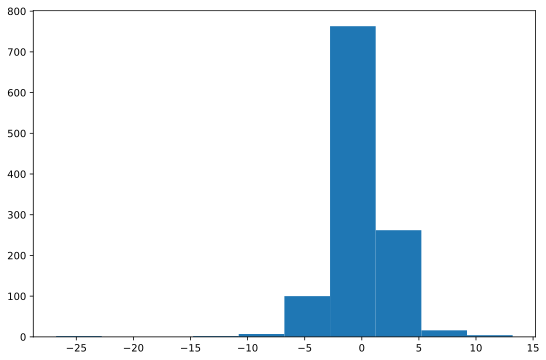

In [34]:
print("Class 1, % (balance): ", y.mean())
_ = plt.hist(y_reg)

In [35]:
idx_train = X.index < datetime.strptime('01.01.2016', '%d.%m.%Y')
idx_test = X.index >= datetime.strptime('01.01.2016', '%d.%m.%Y')

X_train, X_test = X[idx_train], X[idx_test]
tokens_train, tokens_test = tokens[idx_train], tokens[idx_test]
y_train, y_test = y[idx_train], y[idx_test]

X_train.shape[0], X_test.shape[0]

(901, 255)

In [36]:
preprocessing = [TfidfVectorizer(), HashingVectorizer(non_negative=True), CountVectorizer()]
models = {
    RandomForestClassifier(random_state=RANDOM_SEED, class_weight="balanced"): dict(
        model__n_estimators=np.linspace(100, 2000, 15, dtype=np.int), 
        model__max_depth=[5, 10, 15, 20]
    ),
    LogisticRegression(random_state=RANDOM_SEED, class_weight="balanced"): dict(
        model__C=np.logspace(-4, 1, 15)
    ),
    MultinomialNB(): dict(model__alpha=np.logspace(-4, 1, 15, base=10))
}
SKF = StratifiedKFold(2, shuffle=True, random_state=RANDOM_SEED)

In [37]:
def train_clf_models(X_train: np.ndarray, y_train: np.ndarray,
                     X_test: np.ndarray, y_test: np.ndarray,
                     models: dict=models, preprocessing: list=preprocessing,
                     n_iter: int=10) -> tuple:
    scores = []
    names = []
    best_params = []
    for model, params in models.items():
        for vect in preprocessing:
            name = "::".join([model.__class__.__name__, vect.__class__.__name__])
            logging.info("Fiting %s", name)
            cvr_grid = RandomizedSearchCV(
                Pipeline([("vect", vect), ("model", model)]),
                params,
                n_iter=n_iter,
                scoring="accuracy",
                cv=SKF,
                random_state=RANDOM_SEED,
                return_train_score=True
            )
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                _ = cvr_grid.fit(X_train, y_train.ravel())
                y_hat = cvr_grid.predict(X_test)
            logging.info("Params:\t%s", cvr_grid.best_params_)
            logging.info("Accuracy:\t%s", accuracy_score(y_test, y_hat))
            logging.info("F-score:\t%s", f1_score(y_test, y_hat))
            names.append(name)
            scores.append(cvr_grid.cv_results_)
            best_params.append(cvr_grid.best_params_)
    return scores, best_params, names

def plot_results(scores: list, models: list=None) -> None:
    fig, ax = plt.subplots(len(scores) // 3, 3)
    for idx, score in enumerate(scores):
        _ = ax[idx // 3, idx % 3].plot(score['mean_test_score'], label="test")
        _ = ax[idx // 3, idx % 3].plot(score['mean_train_score'], label="train")
        _ = ax[idx // 3, idx % 3].legend()
        if models:
            _ = ax[idx // 3, idx % 3].set_title(models[idx])

#### baseline 

In [85]:
%%time
scores, best_params, models_names = train_clf_models(X_train.Tokens, y_train, X_test.Tokens, y_test)

INFO:root:Fiting MultinomialNB::TfidfVectorizer
INFO:root:Params:	{'model__alpha': 10.0}
INFO:root:Accuracy:	0.517647058824
INFO:root:F-score:	0.0610687022901
INFO:root:Fiting MultinomialNB::HashingVectorizer
INFO:root:Params:	{'model__alpha': 0.16378937069540647}
INFO:root:Accuracy:	0.521568627451
INFO:root:F-score:	0.314606741573
INFO:root:Fiting MultinomialNB::CountVectorizer
INFO:root:Params:	{'model__alpha': 0.0061054022965853268}
INFO:root:Accuracy:	0.545098039216
INFO:root:F-score:	0.5
INFO:root:Fiting LogisticRegression::TfidfVectorizer
INFO:root:Params:	{'model__C': 4.3939705607607946}
INFO:root:Accuracy:	0.533333333333
INFO:root:F-score:	0.514285714286
INFO:root:Fiting LogisticRegression::HashingVectorizer
INFO:root:Params:	{'model__C': 0.84834289824407261}
INFO:root:Accuracy:	0.478431372549
INFO:root:F-score:	0.419213973799
INFO:root:Fiting LogisticRegression::CountVectorizer
INFO:root:Params:	{'model__C': 0.0061054022965853268}
INFO:root:Accuracy:	0.450980392157
INFO:root:F

CPU times: user 9min 2s, sys: 710 ms, total: 9min 2s
Wall time: 9min 3s


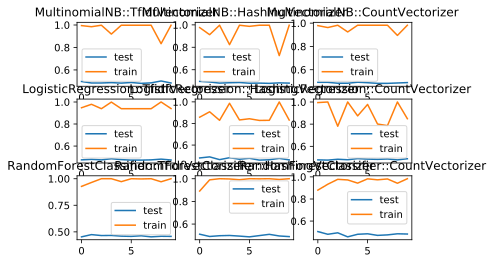

In [93]:
plot_results(scores, models_names)

## Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     

In [38]:
import os
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec, KeyedVectors

#### Попытка обучения только на одних существительных.

In [67]:
%%time
scores_nouns, best_params_nouns, models_names_nouns = train_clf_models(
    X_train.Nouns, y_train, X_test.Nouns, y_test
)

INFO:root:Fiting MultinomialNB with TfidfVectorizer
INFO:root:Params:	{'model__alpha': 0.0061054022965853268}
INFO:root:Accuracy:	0.494117647059
INFO:root:F-score:	0.460251046025
INFO:root:Fiting MultinomialNB with HashingVectorizer
INFO:root:Params:	{'model__alpha': 0.0061054022965853268}
INFO:root:Accuracy:	0.494117647059
INFO:root:F-score:	0.4
INFO:root:Fiting MultinomialNB with CountVectorizer
INFO:root:Params:	{'model__alpha': 0.0061054022965853268}
INFO:root:Accuracy:	0.482352941176
INFO:root:F-score:	0.459016393443
INFO:root:Fiting LogisticRegression with TfidfVectorizer
INFO:root:Params:	{'model__C': 10.0}
INFO:root:Accuracy:	0.517647058824
INFO:root:F-score:	0.481012658228
INFO:root:Fiting LogisticRegression with HashingVectorizer
INFO:root:Params:	{'model__C': 4.3939705607607946}
INFO:root:Accuracy:	0.521568627451
INFO:root:F-score:	0.455357142857
INFO:root:Fiting LogisticRegression with CountVectorizer
INFO:root:Params:	{'model__C': 10.0}
INFO:root:Accuracy:	0.533333333333
I

CPU times: user 10min 31s, sys: 730 ms, total: 10min 32s
Wall time: 10min 33s


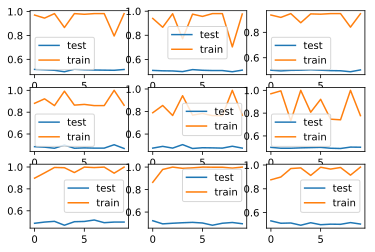

In [167]:
plot_results(scores_nouns, models_names_nouns)

Качество модели возрасло.

#### LDA

In [57]:
from nltk.stem.porter import PorterStemmer
from gensim.models.ldamodel import LdaModel
stemmer = PorterStemmer()

In [55]:
articles_up = [] # делим на стать, при которых акции выросли
articles_down = [] # и упали
drop_words = ['нефть', 'газ'] # вне зависимости от статьи висят в топе, поэтому выкидывпаем эти слова
for idx, el in enumerate(X_train.Tokens):
    stemmed_tokens = [stemmer.stem(i) for i in el.split() if i not in drop_words]
    if y[idx][0]:
        articles_up.append(stemmed_tokens)
    else:
        articles_down.append(stemmed_tokens)
    
dict_corp_up = corpora.Dictionary(articles_up)
dict_corp_down = corpora.Dictionary(articles_down)
corpus_up = [dict_corp_up.doc2bow(el) for el in articles_up]
corpus_down = [dict_corp_down.doc2bow(el) for el in articles_down]

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(4571 unique tokens: ['высокопоставленный', 'офис', 'также', 'абк', 'тува']...) from 439 documents (total 29035 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(4692 unique tokens: ['высокопоставленный', 'офис', 'вылет', 'дестабилизация', 'томбинский']...) from 462 documents (total 30297 corpus positions)


In [58]:
topics_up = []
for num in range(5,10):
    ldamodel = LdaModel(corpus_up, num_topics=num, id2word = dict_corp_up, passes=20)
    topics_up.append(ldamodel.print_topics(num_topics=num, num_words=5))

INFO:gensim.models.ldamodel:using symmetric alpha at 0.2
INFO:gensim.models.ldamodel:using symmetric eta at 0.2
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 5 topics, 20 passes over the supplied corpus of 439 documents, updating model once every 439 documents, evaluating perplexity every 439 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:-9.531 per-word bound, 739.9 perplexity estimate based on a held-out corpus of 439 documents with 29035 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #439/439
INFO:gensim.models.ldamodel:topic #0 (0.200): 0.007*"россия" + 0.007*"сообщать" + 0.006*"поставка" + 0.006*"цена" + 0.006*"российский" + 0.005*"рынок" + 0.005*"украина" + 0.004*"проект" + 0.004*"роснефть" + 0.004*"получать"
INFO:gensim.models.ldamodel:topic #1 (0.200): 0.014*"российский" + 0.008*"проект" + 0.008*"сообщать" + 0.006*"поставка" +

INFO:gensim.models.ldamodel:topic #3 (0.200): 0.006*"проект" + 0.006*"холдинг" + 0.006*"сообщать" + 0.006*"российский" + 0.005*"месторождение" + 0.005*"газпромбанк" + 0.004*"получать" + 0.004*"рынок" + 0.004*"группа" + 0.004*"поставка"
INFO:gensim.models.ldamodel:topic #4 (0.200): 0.012*"проект" + 0.008*"сообщать" + 0.007*"поставка" + 0.007*"российский" + 0.005*"газопровод" + 0.005*"украина" + 0.004*"газовый" + 0.004*"россия" + 0.004*"объем" + 0.004*"спг"
INFO:gensim.models.ldamodel:topic diff=0.101488, rho=0.377964
INFO:gensim.models.ldamodel:-7.841 per-word bound, 229.3 perplexity estimate based on a held-out corpus of 439 documents with 29035 words
INFO:gensim.models.ldamodel:PROGRESS: pass 6, at document #439/439
INFO:gensim.models.ldamodel:topic #0 (0.200): 0.007*"цена" + 0.007*"сообщать" + 0.006*"россия" + 0.006*"российский" + 0.005*"украина" + 0.005*"роснефть" + 0.005*"рынок" + 0.005*"поставка" + 0.004*"первый" + 0.004*"доля"
INFO:gensim.models.ldamodel:topic #1 (0.200): 0.014*"

INFO:gensim.models.ldamodel:topic #3 (0.200): 0.006*"проект" + 0.006*"холдинг" + 0.005*"российский" + 0.005*"сообщать" + 0.005*"месторождение" + 0.005*"газпромбанк" + 0.004*"получать" + 0.004*"группа" + 0.004*"рынок" + 0.004*"поставка"
INFO:gensim.models.ldamodel:topic #4 (0.200): 0.012*"проект" + 0.008*"сообщать" + 0.007*"российский" + 0.007*"поставка" + 0.006*"газопровод" + 0.005*"газовый" + 0.004*"украина" + 0.004*"спг" + 0.004*"объем" + 0.004*"завод"
INFO:gensim.models.ldamodel:topic diff=0.019252, rho=0.277350
INFO:gensim.models.ldamodel:-7.826 per-word bound, 226.9 perplexity estimate based on a held-out corpus of 439 documents with 29035 words
INFO:gensim.models.ldamodel:PROGRESS: pass 12, at document #439/439
INFO:gensim.models.ldamodel:topic #0 (0.200): 0.007*"цена" + 0.007*"сообщать" + 0.006*"россия" + 0.006*"российский" + 0.006*"украина" + 0.005*"роснефть" + 0.005*"поставка" + 0.005*"рынок" + 0.005*"первый" + 0.004*"доля"
INFO:gensim.models.ldamodel:topic #1 (0.200): 0.014*"

INFO:gensim.models.ldamodel:topic #3 (0.200): 0.006*"холдинг" + 0.006*"проект" + 0.005*"сообщать" + 0.005*"российский" + 0.005*"месторождение" + 0.005*"газпромбанк" + 0.004*"получать" + 0.004*"группа" + 0.004*"рынок" + 0.004*"газпром-медиа"
INFO:gensim.models.ldamodel:topic #4 (0.200): 0.012*"проект" + 0.008*"сообщать" + 0.007*"российский" + 0.007*"поставка" + 0.006*"газопровод" + 0.005*"газовый" + 0.005*"спг" + 0.004*"украина" + 0.004*"stream" + 0.004*"объем"
INFO:gensim.models.ldamodel:topic diff=0.007750, rho=0.229416
INFO:gensim.models.ldamodel:-7.821 per-word bound, 226.1 perplexity estimate based on a held-out corpus of 439 documents with 29035 words
INFO:gensim.models.ldamodel:PROGRESS: pass 18, at document #439/439
INFO:gensim.models.ldamodel:topic #0 (0.200): 0.007*"цена" + 0.007*"сообщать" + 0.006*"россия" + 0.006*"российский" + 0.006*"украина" + 0.005*"роснефть" + 0.005*"поставка" + 0.005*"рынок" + 0.005*"первый" + 0.005*"доля"
INFO:gensim.models.ldamodel:topic #1 (0.200): 0

INFO:gensim.models.ldamodel:topic #4 (0.167): 0.012*"сообщать" + 0.007*"российский" + 0.007*"директор" + 0.006*"совет" + 0.005*"проект" + 0.005*"первый" + 0.005*"акция" + 0.004*"дивиденд" + 0.004*"месторождение" + 0.004*"сообщение"
INFO:gensim.models.ldamodel:topic #2 (0.167): 0.010*"цена" + 0.007*"сообщать" + 0.007*"прибыль" + 0.007*"месторождение" + 0.006*"российский" + 0.005*"россия" + 0.005*"чистый" + 0.005*"рынок" + 0.005*"актив" + 0.005*"говориться"
INFO:gensim.models.ldamodel:topic diff=0.384405, rho=0.500000
INFO:gensim.models.ldamodel:-7.911 per-word bound, 240.7 perplexity estimate based on a held-out corpus of 439 documents with 29035 words
INFO:gensim.models.ldamodel:PROGRESS: pass 3, at document #439/439
INFO:gensim.models.ldamodel:topic #5 (0.167): 0.017*"российский" + 0.009*"рынок" + 0.007*"поставка" + 0.007*"новый" + 0.007*"контракт" + 0.006*"проект" + 0.006*"монополия" + 0.005*"получать" + 0.004*"цена" + 0.004*"сообщать"
INFO:gensim.models.ldamodel:topic #1 (0.167): 0.

INFO:gensim.models.ldamodel:topic #3 (0.167): 0.010*"сообщать" + 0.009*"российский" + 0.009*"проект" + 0.008*"поставка" + 0.008*"банк" + 0.007*"газпромбанк" + 0.006*"россия" + 0.006*"рынок" + 0.005*"газовый" + 0.004*"страна"
INFO:gensim.models.ldamodel:topic #4 (0.167): 0.012*"сообщать" + 0.008*"директор" + 0.007*"совет" + 0.007*"российский" + 0.006*"акция" + 0.006*"дивиденд" + 0.005*"проект" + 0.005*"первый" + 0.004*"месторождение" + 0.004*"сообщение"
INFO:gensim.models.ldamodel:topic #5 (0.167): 0.017*"российский" + 0.009*"рынок" + 0.008*"контракт" + 0.007*"поставка" + 0.007*"новый" + 0.006*"проект" + 0.006*"монополия" + 0.005*"получать" + 0.005*"спг" + 0.004*"цена"
INFO:gensim.models.ldamodel:topic diff=0.048286, rho=0.316228
INFO:gensim.models.ldamodel:-7.844 per-word bound, 229.8 perplexity estimate based on a held-out corpus of 439 documents with 29035 words
INFO:gensim.models.ldamodel:PROGRESS: pass 9, at document #439/439
INFO:gensim.models.ldamodel:topic #0 (0.167): 0.005*"про

INFO:gensim.models.ldamodel:topic #1 (0.167): 0.009*"сообщать" + 0.009*"проект" + 0.009*"российский" + 0.007*"роснефть" + 0.007*"украина" + 0.007*"поставка" + 0.006*"газопровод" + 0.005*"газовый" + 0.005*"монополия" + 0.005*"россия"
INFO:gensim.models.ldamodel:topic #5 (0.167): 0.017*"российский" + 0.009*"рынок" + 0.008*"контракт" + 0.007*"поставка" + 0.007*"новый" + 0.006*"проект" + 0.006*"монополия" + 0.005*"получать" + 0.005*"спг" + 0.004*"цена"
INFO:gensim.models.ldamodel:topic #3 (0.167): 0.010*"сообщать" + 0.009*"российский" + 0.009*"проект" + 0.008*"поставка" + 0.008*"банк" + 0.007*"газпромбанк" + 0.006*"россия" + 0.006*"рынок" + 0.005*"газовый" + 0.004*"страна"
INFO:gensim.models.ldamodel:topic #2 (0.167): 0.012*"цена" + 0.009*"прибыль" + 0.007*"российский" + 0.007*"месторождение" + 0.006*"чистый" + 0.006*"сообщать" + 0.005*"говориться" + 0.005*"россия" + 0.005*"холдинг" + 0.005*"актив"
INFO:gensim.models.ldamodel:topic diff=0.013399, rho=0.250000
INFO:gensim.models.ldamodel:-7

INFO:gensim.models.ldamodel:topic #2 (0.167): 0.012*"цена" + 0.010*"прибыль" + 0.007*"российский" + 0.007*"месторождение" + 0.007*"чистый"
INFO:gensim.models.ldamodel:topic #3 (0.167): 0.010*"сообщать" + 0.009*"российский" + 0.009*"проект" + 0.008*"поставка" + 0.008*"банк"
INFO:gensim.models.ldamodel:topic #4 (0.167): 0.012*"сообщать" + 0.008*"директор" + 0.008*"совет" + 0.007*"российский" + 0.006*"акция"
INFO:gensim.models.ldamodel:topic #5 (0.167): 0.017*"российский" + 0.009*"рынок" + 0.008*"контракт" + 0.007*"поставка" + 0.007*"новый"
INFO:gensim.models.ldamodel:using symmetric alpha at 0.14285714285714285
INFO:gensim.models.ldamodel:using symmetric eta at 0.14285714285714285
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 7 topics, 20 passes over the supplied corpus of 439 documents, updating model once every 439 documents, evaluating perplexity every 439 documents, iterating 50x with a converge

INFO:gensim.models.ldamodel:topic #4 (0.143): 0.011*"сообщать" + 0.010*"российский" + 0.008*"украина" + 0.007*"поставка" + 0.007*"проект" + 0.005*"новый" + 0.005*"цена" + 0.005*"алексей" + 0.005*"россия" + 0.004*"рынок"
INFO:gensim.models.ldamodel:topic #6 (0.143): 0.013*"российский" + 0.010*"прибыль" + 0.009*"сообщать" + 0.007*"чистый" + 0.006*"холдинг" + 0.005*"новатэк" + 0.005*"газовый" + 0.005*"газпромбанк" + 0.004*"крупный" + 0.004*"отчет"
INFO:gensim.models.ldamodel:topic #1 (0.143): 0.009*"цена" + 0.009*"российский" + 0.008*"проект" + 0.007*"сообщать" + 0.005*"монополия" + 0.005*"новый" + 0.005*"россия" + 0.005*"рынок" + 0.005*"газовый" + 0.005*"поставка"
INFO:gensim.models.ldamodel:topic #0 (0.143): 0.007*"сообщать" + 0.006*"получать" + 0.006*"проект" + 0.006*"рынок" + 0.006*"крупный" + 0.005*"холдинг" + 0.005*"сделка" + 0.005*"группа" + 0.004*"роснефть" + 0.004*"газпром-медиа"
INFO:gensim.models.ldamodel:topic diff=0.151226, rho=0.377964
INFO:gensim.models.ldamodel:-7.879 per-

INFO:gensim.models.ldamodel:topic #0 (0.143): 0.007*"сообщать" + 0.006*"проект" + 0.006*"получать" + 0.006*"крупный" + 0.006*"рынок" + 0.005*"холдинг" + 0.005*"группа" + 0.005*"сделка" + 0.005*"газпром-медиа" + 0.004*"тнт"
INFO:gensim.models.ldamodel:topic #5 (0.143): 0.010*"цена" + 0.008*"роснефть" + 0.007*"рынок" + 0.007*"литва" + 0.006*"совет" + 0.005*"россия" + 0.005*"российский" + 0.005*"монополия" + 0.005*"lietuvo" + 0.005*"dujo"
INFO:gensim.models.ldamodel:topic #6 (0.143): 0.013*"российский" + 0.011*"прибыль" + 0.009*"сообщать" + 0.008*"чистый" + 0.006*"холдинг" + 0.005*"новатэк" + 0.005*"газовый" + 0.005*"газпромбанк" + 0.005*"отчет" + 0.005*"квартал"
INFO:gensim.models.ldamodel:topic #4 (0.143): 0.011*"сообщать" + 0.010*"российский" + 0.008*"украина" + 0.007*"поставка" + 0.007*"проект" + 0.005*"новый" + 0.005*"алексей" + 0.005*"цена" + 0.005*"миллер" + 0.005*"россия"
INFO:gensim.models.ldamodel:topic diff=0.027404, rho=0.277350
INFO:gensim.models.ldamodel:-7.857 per-word boun

INFO:gensim.models.ldamodel:topic #4 (0.143): 0.011*"сообщать" + 0.010*"российский" + 0.008*"украина" + 0.007*"поставка" + 0.007*"проект" + 0.006*"алексей" + 0.005*"новый" + 0.005*"миллер" + 0.005*"цена" + 0.005*"россия"
INFO:gensim.models.ldamodel:topic #6 (0.143): 0.013*"российский" + 0.011*"прибыль" + 0.009*"сообщать" + 0.008*"чистый" + 0.006*"холдинг" + 0.005*"новатэк" + 0.005*"газовый" + 0.005*"газпромбанк" + 0.005*"отчет" + 0.005*"квартал"
INFO:gensim.models.ldamodel:topic #5 (0.143): 0.010*"цена" + 0.008*"роснефть" + 0.007*"рынок" + 0.007*"литва" + 0.007*"совет" + 0.005*"lietuvo" + 0.005*"россия" + 0.005*"монополия" + 0.005*"российский" + 0.005*"dujo"
INFO:gensim.models.ldamodel:topic #2 (0.143): 0.011*"поставка" + 0.010*"проект" + 0.010*"российский" + 0.007*"рынок" + 0.007*"сообщать" + 0.005*"сообщение" + 0.005*"россия" + 0.005*"газопровод" + 0.005*"газпромбанк" + 0.004*"банк"
INFO:gensim.models.ldamodel:topic diff=0.009424, rho=0.229416
INFO:gensim.models.ldamodel:-7.850 per-w

INFO:gensim.models.ldamodel:topic #1 (0.125): 0.012*"сообщать" + 0.008*"российский" + 0.006*"рынок" + 0.006*"поставка" + 0.005*"первый" + 0.005*"объем" + 0.005*"составлять" + 0.005*"газовый" + 0.004*"алексей" + 0.004*"доля"
INFO:gensim.models.ldamodel:topic #6 (0.125): 0.009*"проект" + 0.008*"российский" + 0.008*"россия" + 0.006*"поставка" + 0.006*"сообщать" + 0.005*"рынок" + 0.005*"актив" + 0.005*"цена" + 0.005*"монополия" + 0.005*"украина"
INFO:gensim.models.ldamodel:topic #4 (0.125): 0.008*"поставка" + 0.008*"сообщать" + 0.007*"российский" + 0.007*"месторождение" + 0.005*"банк" + 0.005*"монополия" + 0.005*"новый" + 0.005*"прибыль" + 0.005*"составлять" + 0.005*"газовый"
INFO:gensim.models.ldamodel:topic #5 (0.125): 0.010*"получать" + 0.009*"сообщать" + 0.008*"проект" + 0.008*"российский" + 0.007*"роснефть" + 0.007*"новый" + 0.006*"прибыль" + 0.006*"месторождение" + 0.005*"газовый" + 0.005*"чистый"
INFO:gensim.models.ldamodel:topic diff=0.465214, rho=0.500000
INFO:gensim.models.ldamod

INFO:gensim.models.ldamodel:topic #7 (0.125): 0.013*"российский" + 0.012*"украина" + 0.009*"поставка" + 0.008*"сообщать" + 0.008*"холдинг" + 0.008*"цена" + 0.008*"газовый" + 0.007*"проект" + 0.006*"россия" + 0.005*"сказать"
INFO:gensim.models.ldamodel:topic #2 (0.125): 0.008*"российский" + 0.008*"монополия" + 0.007*"проект" + 0.007*"цена" + 0.007*"рынок" + 0.005*"получать" + 0.005*"газопровод" + 0.005*"роснефть" + 0.005*"крупный" + 0.005*"поставка"
INFO:gensim.models.ldamodel:topic #0 (0.125): 0.009*"проект" + 0.008*"сообщать" + 0.007*"банк" + 0.007*"рынок" + 0.006*"российский" + 0.006*"совет" + 0.005*"спг" + 0.005*"решение" + 0.005*"директор" + 0.005*"роснефть"
INFO:gensim.models.ldamodel:topic #6 (0.125): 0.008*"проект" + 0.008*"российский" + 0.007*"россия" + 0.006*"поставка" + 0.006*"сообщать" + 0.005*"рынок" + 0.005*"цена" + 0.005*"актив" + 0.005*"монополия" + 0.005*"строительство"
INFO:gensim.models.ldamodel:topic diff=0.061718, rho=0.316228
INFO:gensim.models.ldamodel:-7.880 per-

INFO:gensim.models.ldamodel:topic #2 (0.125): 0.008*"российский" + 0.008*"монополия" + 0.008*"цена" + 0.007*"проект" + 0.007*"рынок" + 0.005*"получать" + 0.005*"газопровод" + 0.005*"роснефть" + 0.005*"крупный" + 0.005*"поставка"
INFO:gensim.models.ldamodel:topic #7 (0.125): 0.013*"российский" + 0.012*"украина" + 0.009*"поставка" + 0.008*"сообщать" + 0.008*"холдинг" + 0.008*"цена" + 0.008*"газовый" + 0.007*"проект" + 0.006*"россия" + 0.005*"сказать"
INFO:gensim.models.ldamodel:topic #5 (0.125): 0.009*"получать" + 0.009*"прибыль" + 0.008*"проект" + 0.008*"сообщать" + 0.008*"роснефть" + 0.007*"новый" + 0.007*"месторождение" + 0.007*"чистый" + 0.006*"российский" + 0.006*"шельф"
INFO:gensim.models.ldamodel:topic #1 (0.125): 0.012*"сообщать" + 0.007*"российский" + 0.006*"первый" + 0.006*"рынок" + 0.006*"поставка" + 0.005*"объем" + 0.005*"сообщение" + 0.005*"составлять" + 0.005*"говориться" + 0.005*"доля"
INFO:gensim.models.ldamodel:topic diff=0.016622, rho=0.250000
INFO:gensim.models.ldamode

INFO:gensim.models.ldamodel:topic #2 (0.125): 0.008*"российский" + 0.008*"монополия" + 0.008*"цена" + 0.007*"проект" + 0.007*"рынок"
INFO:gensim.models.ldamodel:topic #3 (0.125): 0.011*"российский" + 0.010*"сообщать" + 0.009*"совет" + 0.007*"роснефть" + 0.007*"директор"
INFO:gensim.models.ldamodel:topic #4 (0.125): 0.008*"поставка" + 0.008*"сообщать" + 0.008*"российский" + 0.007*"месторождение" + 0.006*"банк"
INFO:gensim.models.ldamodel:topic #5 (0.125): 0.010*"прибыль" + 0.009*"получать" + 0.008*"проект" + 0.008*"сообщать" + 0.008*"роснефть"
INFO:gensim.models.ldamodel:topic #6 (0.125): 0.008*"проект" + 0.008*"российский" + 0.008*"россия" + 0.006*"поставка" + 0.006*"сообщать"
INFO:gensim.models.ldamodel:topic #7 (0.125): 0.013*"украина" + 0.013*"российский" + 0.009*"поставка" + 0.009*"сообщать" + 0.008*"холдинг"
INFO:gensim.models.ldamodel:using symmetric alpha at 0.1111111111111111
INFO:gensim.models.ldamodel:using symmetric eta at 0.1111111111111111
INFO:gensim.models.ldamodel:using

INFO:gensim.models.ldamodel:topic diff=0.254887, rho=0.408248
INFO:gensim.models.ldamodel:-7.955 per-word bound, 248.1 perplexity estimate based on a held-out corpus of 439 documents with 29035 words
INFO:gensim.models.ldamodel:PROGRESS: pass 5, at document #439/439
INFO:gensim.models.ldamodel:topic #7 (0.111): 0.011*"сообщать" + 0.009*"поставка" + 0.008*"российский" + 0.008*"банк" + 0.007*"цена" + 0.006*"россия" + 0.006*"получать" + 0.006*"монополия" + 0.005*"прибыль" + 0.005*"сказать"
INFO:gensim.models.ldamodel:topic #0 (0.111): 0.014*"проект" + 0.009*"российский" + 0.008*"газовый" + 0.006*"сообщать" + 0.006*"немецкий" + 0.006*"месторождение" + 0.005*"актив" + 0.005*"газопровод" + 0.005*"получать" + 0.005*"строительство"
INFO:gensim.models.ldamodel:topic #1 (0.111): 0.012*"российский" + 0.011*"цена" + 0.010*"россия" + 0.009*"украина" + 0.009*"рынок" + 0.007*"поставка" + 0.006*"сообщать" + 0.005*"роснефть" + 0.005*"кубометр" + 0.005*"проект"
INFO:gensim.models.ldamodel:topic #8 (0.11

INFO:gensim.models.ldamodel:topic #7 (0.111): 0.011*"сообщать" + 0.009*"поставка" + 0.008*"российский" + 0.008*"банк" + 0.007*"цена" + 0.006*"россия" + 0.006*"получать" + 0.006*"монополия" + 0.005*"сказать" + 0.005*"рынок"
INFO:gensim.models.ldamodel:topic diff=0.043887, rho=0.288675
INFO:gensim.models.ldamodel:-7.910 per-word bound, 240.5 perplexity estimate based on a held-out corpus of 439 documents with 29035 words
INFO:gensim.models.ldamodel:PROGRESS: pass 11, at document #439/439
INFO:gensim.models.ldamodel:topic #7 (0.111): 0.011*"сообщать" + 0.009*"поставка" + 0.008*"российский" + 0.008*"банк" + 0.007*"цена" + 0.006*"россия" + 0.006*"получать" + 0.006*"монополия" + 0.005*"сказать" + 0.005*"рынок"
INFO:gensim.models.ldamodel:topic #0 (0.111): 0.014*"проект" + 0.009*"российский" + 0.008*"газовый" + 0.007*"немецкий" + 0.006*"сообщать" + 0.006*"газопровод" + 0.006*"месторождение" + 0.006*"актив" + 0.006*"строительство" + 0.006*"спг"
INFO:gensim.models.ldamodel:topic #4 (0.111): 0.0

INFO:gensim.models.ldamodel:topic #7 (0.111): 0.011*"сообщать" + 0.009*"поставка" + 0.008*"российский" + 0.008*"банк" + 0.007*"цена" + 0.006*"россия" + 0.006*"получать" + 0.006*"монополия" + 0.005*"сказать" + 0.005*"рынок"
INFO:gensim.models.ldamodel:topic #4 (0.111): 0.011*"говориться" + 0.011*"прибыль" + 0.009*"сообщение" + 0.008*"российский" + 0.008*"холдинг" + 0.008*"акция" + 0.007*"сообщать" + 0.006*"чистый" + 0.006*"составлять" + 0.006*"газовый"
INFO:gensim.models.ldamodel:topic diff=0.013552, rho=0.235702
INFO:gensim.models.ldamodel:-7.900 per-word bound, 238.8 perplexity estimate based on a held-out corpus of 439 documents with 29035 words
INFO:gensim.models.ldamodel:PROGRESS: pass 17, at document #439/439
INFO:gensim.models.ldamodel:topic #1 (0.111): 0.012*"российский" + 0.011*"цена" + 0.010*"россия" + 0.010*"украина" + 0.009*"рынок" + 0.008*"поставка" + 0.006*"кубометр" + 0.006*"роснефть" + 0.005*"сообщать" + 0.005*"европа"
INFO:gensim.models.ldamodel:topic #4 (0.111): 0.011*

In [59]:
num = 5
for topic in topics_up:
    print('! num_topics =', num)
    for el in topic:
        print('   ', el)
    num += 1

! num_topics = 5
    (0, '0.007*"цена" + 0.007*"сообщать" + 0.006*"россия" + 0.006*"украина" + 0.006*"российский"')
    (1, '0.014*"российский" + 0.012*"сообщать" + 0.006*"прибыль" + 0.006*"проект" + 0.006*"газовый"')
    (2, '0.010*"российский" + 0.008*"сообщать" + 0.007*"рынок" + 0.007*"цена" + 0.006*"монополия"')
    (3, '0.006*"холдинг" + 0.006*"проект" + 0.005*"сообщать" + 0.005*"российский" + 0.005*"месторождение"')
    (4, '0.013*"проект" + 0.008*"сообщать" + 0.007*"российский" + 0.007*"поставка" + 0.006*"газопровод"')
! num_topics = 6
    (0, '0.005*"проект" + 0.004*"поставка" + 0.004*"российский" + 0.004*"холдинг" + 0.004*"мощность"')
    (1, '0.009*"сообщать" + 0.009*"проект" + 0.008*"российский" + 0.007*"роснефть" + 0.007*"украина"')
    (2, '0.012*"цена" + 0.010*"прибыль" + 0.007*"российский" + 0.007*"месторождение" + 0.007*"чистый"')
    (3, '0.010*"сообщать" + 0.009*"российский" + 0.009*"проект" + 0.008*"поставка" + 0.008*"банк"')
    (4, '0.012*"сообщать" + 0.008*"директ

In [60]:
topics_down = []
for num in range(5,10):
    ldamodel = LdaModel(corpus_down, num_topics=num, id2word = dict_corp_down, passes=20)
    topics_down.append(ldamodel.print_topics(num_topics=num, num_words=5))

INFO:gensim.models.ldamodel:using symmetric alpha at 0.2
INFO:gensim.models.ldamodel:using symmetric eta at 0.2
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 5 topics, 20 passes over the supplied corpus of 462 documents, updating model once every 462 documents, evaluating perplexity every 462 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:-9.545 per-word bound, 747.2 perplexity estimate based on a held-out corpus of 462 documents with 30297 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #462/462
INFO:gensim.models.ldamodel:topic #0 (0.200): 0.010*"проект" + 0.009*"российский" + 0.007*"сообщать" + 0.006*"поставка" + 0.004*"крупный" + 0.004*"газпромбанк" + 0.004*"роснефть" + 0.004*"цена" + 0.004*"россия" + 0.004*"получать"
INFO:gensim.models.ldamodel:topic #1 (0.200): 0.008*"сообщать" + 0.007*"цена" + 0.006*"рынок" + 0.006*"российский" 

INFO:gensim.models.ldamodel:topic #2 (0.200): 0.010*"украина" + 0.007*"газопровод" + 0.006*"сообщать" + 0.006*"российский" + 0.005*"строительство" + 0.005*"газовый" + 0.005*"поставка" + 0.005*"европа" + 0.004*"газпромбанк" + 0.004*"проект"
INFO:gensim.models.ldamodel:topic #3 (0.200): 0.009*"месторождение" + 0.009*"сообщать" + 0.006*"проект" + 0.006*"российский" + 0.005*"россия" + 0.005*"подписывать" + 0.004*"газовый" + 0.004*"директор" + 0.004*"новый" + 0.004*"крупный"
INFO:gensim.models.ldamodel:topic #4 (0.200): 0.011*"поставка" + 0.010*"цена" + 0.010*"российский" + 0.009*"сообщать" + 0.007*"газовый" + 0.007*"украина" + 0.007*"монополия" + 0.006*"сказать" + 0.005*"александр" + 0.005*"европа"
INFO:gensim.models.ldamodel:topic diff=0.104908, rho=0.377964
INFO:gensim.models.ldamodel:-7.834 per-word bound, 228.1 perplexity estimate based on a held-out corpus of 462 documents with 30297 words
INFO:gensim.models.ldamodel:PROGRESS: pass 6, at document #462/462
INFO:gensim.models.ldamodel:t

INFO:gensim.models.ldamodel:topic #1 (0.200): 0.008*"сообщать" + 0.008*"цена" + 0.006*"монополия" + 0.006*"крупный" + 0.005*"рынок" + 0.005*"российский" + 0.005*"страна" + 0.005*"акционер" + 0.004*"новый" + 0.004*"акция"
INFO:gensim.models.ldamodel:topic #2 (0.200): 0.010*"украина" + 0.007*"газопровод" + 0.007*"сообщать" + 0.006*"строительство" + 0.006*"российский" + 0.005*"поставка" + 0.005*"газовый" + 0.005*"европа" + 0.005*"газпромбанк" + 0.004*"чистый"
INFO:gensim.models.ldamodel:topic #3 (0.200): 0.010*"месторождение" + 0.009*"сообщать" + 0.006*"проект" + 0.006*"российский" + 0.005*"россия" + 0.005*"подписывать" + 0.005*"газовый" + 0.005*"директор" + 0.004*"крупный" + 0.004*"газпромбанк"
INFO:gensim.models.ldamodel:topic #4 (0.200): 0.012*"поставка" + 0.010*"российский" + 0.010*"цена" + 0.009*"сообщать" + 0.007*"украина" + 0.007*"газовый" + 0.007*"монополия" + 0.006*"сказать" + 0.006*"александр" + 0.005*"европа"
INFO:gensim.models.ldamodel:topic diff=0.021283, rho=0.277350
INFO:ge

INFO:gensim.models.ldamodel:PROGRESS: pass 17, at document #462/462
INFO:gensim.models.ldamodel:topic #0 (0.200): 0.010*"проект" + 0.008*"российский" + 0.006*"роснефть" + 0.005*"получать" + 0.005*"акция" + 0.005*"крупный" + 0.005*"спг" + 0.004*"сообщать" + 0.004*"правительство" + 0.004*"новатэк"
INFO:gensim.models.ldamodel:topic #1 (0.200): 0.008*"сообщать" + 0.008*"цена" + 0.006*"монополия" + 0.006*"крупный" + 0.005*"рынок" + 0.005*"российский" + 0.005*"страна" + 0.005*"акционер" + 0.004*"новый" + 0.004*"акция"
INFO:gensim.models.ldamodel:topic #2 (0.200): 0.010*"украина" + 0.008*"газопровод" + 0.007*"сообщать" + 0.006*"строительство" + 0.006*"российский" + 0.005*"поставка" + 0.005*"газпромбанк" + 0.005*"газовый" + 0.005*"европа" + 0.005*"прибыль"
INFO:gensim.models.ldamodel:topic #3 (0.200): 0.010*"месторождение" + 0.009*"сообщать" + 0.007*"проект" + 0.006*"российский" + 0.005*"россия" + 0.005*"газовый" + 0.005*"подписывать" + 0.005*"директор" + 0.004*"крупный" + 0.004*"газпромбанк"


INFO:gensim.models.ldamodel:PROGRESS: pass 2, at document #462/462
INFO:gensim.models.ldamodel:topic #1 (0.167): 0.010*"проект" + 0.007*"получать" + 0.007*"сообщать" + 0.006*"роснефть" + 0.006*"российский" + 0.005*"акция" + 0.005*"месторождение" + 0.005*"рынок" + 0.004*"монополия" + 0.004*"газовый"
INFO:gensim.models.ldamodel:topic #5 (0.167): 0.010*"российский" + 0.007*"цена" + 0.007*"сообщать" + 0.006*"газпромбанк" + 0.005*"газовый" + 0.005*"проект" + 0.005*"украина" + 0.005*"монополия" + 0.005*"европа" + 0.005*"поставка"
INFO:gensim.models.ldamodel:topic #3 (0.167): 0.008*"сообщать" + 0.007*"российский" + 0.007*"газпром-медиа" + 0.005*"холдинг" + 0.004*"газовый" + 0.004*"директор" + 0.004*"новый" + 0.004*"прибыль" + 0.004*"суд" + 0.004*"цена"
INFO:gensim.models.ldamodel:topic #4 (0.167): 0.009*"сообщать" + 0.009*"российский" + 0.008*"поставка" + 0.006*"цена" + 0.006*"украина" + 0.005*"газпромбанк" + 0.005*"крупный" + 0.005*"россия" + 0.005*"месторождение" + 0.004*"банк"
INFO:gensim.

INFO:gensim.models.ldamodel:topic diff=0.060350, rho=0.333333
INFO:gensim.models.ldamodel:-7.855 per-word bound, 231.6 perplexity estimate based on a held-out corpus of 462 documents with 30297 words
INFO:gensim.models.ldamodel:PROGRESS: pass 8, at document #462/462
INFO:gensim.models.ldamodel:topic #2 (0.167): 0.008*"проект" + 0.008*"российский" + 0.006*"газовый" + 0.006*"россия" + 0.005*"объем" + 0.005*"крупный" + 0.005*"сообщать" + 0.005*"роснефть" + 0.005*"поставка" + 0.005*"рынок"
INFO:gensim.models.ldamodel:topic #1 (0.167): 0.010*"проект" + 0.008*"получать" + 0.007*"роснефть" + 0.007*"сообщать" + 0.006*"месторождение" + 0.005*"российский" + 0.005*"монополия" + 0.005*"акция" + 0.005*"рынок" + 0.004*"актив"
INFO:gensim.models.ldamodel:topic #4 (0.167): 0.009*"сообщать" + 0.009*"поставка" + 0.009*"российский" + 0.007*"украина" + 0.007*"цена" + 0.005*"газпромбанк" + 0.005*"россия" + 0.005*"крупный" + 0.005*"сказать" + 0.005*"нафтогаз"
INFO:gensim.models.ldamodel:topic #3 (0.167): 0.

INFO:gensim.models.ldamodel:topic #4 (0.167): 0.010*"поставка" + 0.009*"сообщать" + 0.009*"российский" + 0.008*"украина" + 0.007*"цена" + 0.005*"нафтогаз" + 0.005*"газпромбанк" + 0.005*"россия" + 0.005*"сказать" + 0.005*"крупный"
INFO:gensim.models.ldamodel:topic diff=0.015269, rho=0.258199
INFO:gensim.models.ldamodel:-7.843 per-word bound, 229.6 perplexity estimate based on a held-out corpus of 462 documents with 30297 words
INFO:gensim.models.ldamodel:PROGRESS: pass 14, at document #462/462
INFO:gensim.models.ldamodel:topic #2 (0.167): 0.008*"проект" + 0.008*"российский" + 0.006*"газовый" + 0.006*"россия" + 0.005*"объем" + 0.005*"крупный" + 0.005*"сообщать" + 0.005*"роснефть" + 0.005*"поставка" + 0.004*"рынок"
INFO:gensim.models.ldamodel:topic #1 (0.167): 0.010*"проект" + 0.008*"получать" + 0.007*"роснефть" + 0.006*"сообщать" + 0.006*"месторождение" + 0.005*"российский" + 0.005*"монополия" + 0.005*"рынок" + 0.005*"акция" + 0.004*"актив"
INFO:gensim.models.ldamodel:topic #5 (0.167): 0

INFO:gensim.models.ldamodel:topic #0 (0.167): 0.008*"проект" + 0.008*"газопровод" + 0.007*"сообщать" + 0.007*"цена" + 0.007*"поставка" + 0.006*"российский" + 0.005*"stream" + 0.005*"рынок" + 0.004*"монополия" + 0.004*"украина"
INFO:gensim.models.ldamodel:topic #1 (0.167): 0.010*"проект" + 0.008*"получать" + 0.007*"роснефть" + 0.007*"месторождение" + 0.006*"сообщать" + 0.005*"российский" + 0.005*"монополия" + 0.005*"актив" + 0.005*"рынок" + 0.005*"акция"
INFO:gensim.models.ldamodel:topic diff=0.007394, rho=0.218218
INFO:gensim.models.ldamodel:topic #0 (0.167): 0.008*"проект" + 0.008*"газопровод" + 0.007*"сообщать" + 0.007*"цена" + 0.007*"поставка"
INFO:gensim.models.ldamodel:topic #1 (0.167): 0.010*"проект" + 0.008*"получать" + 0.007*"роснефть" + 0.007*"месторождение" + 0.006*"сообщать"
INFO:gensim.models.ldamodel:topic #2 (0.167): 0.008*"проект" + 0.007*"российский" + 0.006*"газовый" + 0.005*"россия" + 0.005*"объем"
INFO:gensim.models.ldamodel:topic #3 (0.167): 0.009*"сообщать" + 0.009

INFO:gensim.models.ldamodel:topic #6 (0.143): 0.009*"сообщать" + 0.008*"поставка" + 0.007*"составлять" + 0.006*"говориться" + 0.006*"российский" + 0.005*"украина" + 0.005*"прибыль" + 0.005*"директор" + 0.005*"месторождение" + 0.004*"объем"
INFO:gensim.models.ldamodel:topic #2 (0.143): 0.009*"российский" + 0.008*"газпромбанк" + 0.008*"украина" + 0.006*"цена" + 0.005*"поставка" + 0.005*"крупный" + 0.005*"проект" + 0.005*"нефтяной" + 0.005*"месторождение" + 0.004*"монополия"
INFO:gensim.models.ldamodel:topic #1 (0.143): 0.010*"проект" + 0.009*"российский" + 0.008*"газовый" + 0.006*"рынок" + 0.006*"актив" + 0.006*"готовый" + 0.005*"поставка" + 0.005*"сделка" + 0.005*"монополия" + 0.005*"цена"
INFO:gensim.models.ldamodel:topic diff=0.213181, rho=0.408248
INFO:gensim.models.ldamodel:-7.895 per-word bound, 238.1 perplexity estimate based on a held-out corpus of 462 documents with 30297 words
INFO:gensim.models.ldamodel:PROGRESS: pass 5, at document #462/462
INFO:gensim.models.ldamodel:topic #

INFO:gensim.models.ldamodel:topic #1 (0.143): 0.010*"проект" + 0.010*"российский" + 0.008*"газовый" + 0.006*"рынок" + 0.006*"актив" + 0.006*"готовый" + 0.006*"поставка" + 0.005*"сделка" + 0.005*"монополия" + 0.005*"новый"
INFO:gensim.models.ldamodel:topic #3 (0.143): 0.011*"проект" + 0.010*"газопровод" + 0.009*"сообщать" + 0.007*"поток" + 0.007*"российский" + 0.007*"месторождение" + 0.006*"подписывать" + 0.006*"газпром-медиа" + 0.005*"говориться" + 0.005*"южный"
INFO:gensim.models.ldamodel:topic #5 (0.143): 0.014*"сообщать" + 0.009*"российский" + 0.009*"поставка" + 0.007*"правление" + 0.006*"александр" + 0.006*"россия" + 0.006*"миллер" + 0.006*"китай" + 0.005*"проект" + 0.005*"переговоры"
INFO:gensim.models.ldamodel:topic #2 (0.143): 0.009*"украина" + 0.008*"газпромбанк" + 0.008*"российский" + 0.006*"цена" + 0.005*"поставка" + 0.005*"нефтяной" + 0.005*"крупный" + 0.005*"проект" + 0.005*"монополия" + 0.004*"месторождение"
INFO:gensim.models.ldamodel:topic diff=0.037234, rho=0.288675
INF

INFO:gensim.models.ldamodel:PROGRESS: pass 16, at document #462/462
INFO:gensim.models.ldamodel:topic #4 (0.143): 0.011*"цена" + 0.007*"российский" + 0.006*"сообщать" + 0.006*"акция" + 0.006*"монополия" + 0.006*"получать" + 0.005*"крупный" + 0.004*"газпромбанк" + 0.004*"суд" + 0.004*"первый"
INFO:gensim.models.ldamodel:topic #0 (0.143): 0.008*"сообщать" + 0.008*"рынок" + 0.007*"газовый" + 0.007*"европа" + 0.007*"монополия" + 0.006*"новый" + 0.005*"россия" + 0.005*"российский" + 0.005*"поставка" + 0.005*"сказать"
INFO:gensim.models.ldamodel:topic #6 (0.143): 0.010*"сообщать" + 0.008*"поставка" + 0.008*"составлять" + 0.007*"украина" + 0.006*"говориться" + 0.006*"российский" + 0.006*"прибыль" + 0.006*"директор" + 0.005*"совет" + 0.005*"первый"
INFO:gensim.models.ldamodel:topic #5 (0.143): 0.014*"сообщать" + 0.009*"поставка" + 0.009*"российский" + 0.008*"правление" + 0.007*"александр" + 0.006*"миллер" + 0.006*"китай" + 0.006*"россия" + 0.005*"председатель" + 0.005*"переговоры"
INFO:gensim.

INFO:gensim.models.ldamodel:topic diff=3.672392, rho=1.000000
INFO:gensim.models.ldamodel:-8.277 per-word bound, 310.3 perplexity estimate based on a held-out corpus of 462 documents with 30297 words
INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #462/462
INFO:gensim.models.ldamodel:topic #1 (0.125): 0.008*"российский" + 0.008*"проект" + 0.006*"сообщать" + 0.005*"цена" + 0.005*"акция" + 0.005*"суд" + 0.005*"сделка" + 0.005*"газовый" + 0.005*"роснефть" + 0.004*"монополия"
INFO:gensim.models.ldamodel:topic #0 (0.125): 0.009*"сообщать" + 0.006*"монополия" + 0.005*"украина" + 0.005*"российский" + 0.005*"цена" + 0.005*"акция" + 0.004*"составлять" + 0.004*"россия" + 0.004*"газопровод" + 0.004*"поставка"
INFO:gensim.models.ldamodel:topic #7 (0.125): 0.008*"месторождение" + 0.008*"проект" + 0.005*"сообщать" + 0.005*"газпромбанк" + 0.005*"новый" + 0.005*"цена" + 0.004*"российский" + 0.004*"входить" + 0.004*"актив" + 0.004*"газовый"
INFO:gensim.models.ldamodel:topic #5 (0.125): 0.009*

INFO:gensim.models.ldamodel:topic #4 (0.125): 0.010*"российский" + 0.007*"поставка" + 0.006*"проект" + 0.006*"монополия" + 0.005*"месторождение" + 0.005*"украина" + 0.005*"получать" + 0.005*"газопровод" + 0.005*"крупный" + 0.004*"спг"
INFO:gensim.models.ldamodel:topic diff=0.114345, rho=0.353553
INFO:gensim.models.ldamodel:-7.907 per-word bound, 240.0 perplexity estimate based on a held-out corpus of 462 documents with 30297 words
INFO:gensim.models.ldamodel:PROGRESS: pass 7, at document #462/462
INFO:gensim.models.ldamodel:topic #1 (0.125): 0.009*"российский" + 0.008*"проект" + 0.007*"цена" + 0.007*"сообщать" + 0.006*"суд" + 0.006*"акция" + 0.005*"сделка" + 0.005*"роснефть" + 0.005*"газовый" + 0.004*"монополия"
INFO:gensim.models.ldamodel:topic #2 (0.125): 0.011*"сообщать" + 0.009*"российский" + 0.008*"поставка" + 0.007*"проект" + 0.007*"цена" + 0.006*"газовый" + 0.006*"сказать" + 0.005*"миллер" + 0.005*"газопровод" + 0.005*"строительство"
INFO:gensim.models.ldamodel:topic #0 (0.125):

INFO:gensim.models.ldamodel:topic #3 (0.125): 0.010*"цена" + 0.008*"рынок" + 0.007*"российский" + 0.007*"украина" + 0.006*"роснефть" + 0.005*"крупный" + 0.004*"газовый" + 0.004*"месторождение" + 0.004*"сообщать" + 0.004*"акция"
INFO:gensim.models.ldamodel:topic #1 (0.125): 0.009*"российский" + 0.008*"проект" + 0.007*"цена" + 0.006*"сообщать" + 0.006*"суд" + 0.006*"акция" + 0.005*"сделка" + 0.005*"роснефть" + 0.005*"газовый" + 0.005*"монополия"
INFO:gensim.models.ldamodel:topic diff=0.021898, rho=0.267261
INFO:gensim.models.ldamodel:-7.890 per-word bound, 237.2 perplexity estimate based on a held-out corpus of 462 documents with 30297 words
INFO:gensim.models.ldamodel:PROGRESS: pass 13, at document #462/462
INFO:gensim.models.ldamodel:topic #6 (0.125): 0.009*"сообщать" + 0.006*"поставка" + 0.006*"российский" + 0.006*"холдинг" + 0.006*"месторождение" + 0.006*"газпромбанк" + 0.006*"газпром-медиа" + 0.005*"цена" + 0.005*"переговоры" + 0.005*"директор"
INFO:gensim.models.ldamodel:topic #7 (

INFO:gensim.models.ldamodel:topic #5 (0.125): 0.008*"сообщать" + 0.007*"российский" + 0.007*"монополия" + 0.005*"поставка" + 0.005*"газовый" + 0.005*"директор" + 0.005*"проект" + 0.005*"россия" + 0.005*"совет" + 0.005*"переговоры"
INFO:gensim.models.ldamodel:topic #6 (0.125): 0.009*"сообщать" + 0.006*"поставка" + 0.006*"российский" + 0.006*"холдинг" + 0.006*"месторождение" + 0.006*"газпром-медиа" + 0.005*"газпромбанк" + 0.005*"цена" + 0.005*"переговоры" + 0.005*"директор"
INFO:gensim.models.ldamodel:topic #2 (0.125): 0.011*"сообщать" + 0.009*"российский" + 0.008*"поставка" + 0.008*"проект" + 0.007*"цена" + 0.006*"газовый" + 0.006*"сказать" + 0.006*"газопровод" + 0.006*"миллер" + 0.006*"строительство"
INFO:gensim.models.ldamodel:topic diff=0.007554, rho=0.223607
INFO:gensim.models.ldamodel:-7.885 per-word bound, 236.3 perplexity estimate based on a held-out corpus of 462 documents with 30297 words
INFO:gensim.models.ldamodel:PROGRESS: pass 19, at document #462/462
INFO:gensim.models.lda

INFO:gensim.models.ldamodel:PROGRESS: pass 3, at document #462/462
INFO:gensim.models.ldamodel:topic #4 (0.111): 0.012*"сообщать" + 0.009*"цена" + 0.008*"месторождение" + 0.005*"акция" + 0.005*"проект" + 0.005*"монополия" + 0.004*"российский" + 0.004*"суд" + 0.004*"газпромбанк" + 0.004*"газовый"
INFO:gensim.models.ldamodel:topic #1 (0.111): 0.008*"российский" + 0.007*"поставка" + 0.007*"украина" + 0.007*"газпромбанк" + 0.006*"проект" + 0.006*"монополия" + 0.006*"газопровод" + 0.006*"цена" + 0.005*"сообщать" + 0.005*"акция"
INFO:gensim.models.ldamodel:topic #2 (0.111): 0.009*"российский" + 0.009*"проект" + 0.008*"газовый" + 0.007*"монополия" + 0.006*"россия" + 0.006*"сообщать" + 0.005*"цена" + 0.005*"крупный" + 0.004*"говориться" + 0.004*"поставка"
INFO:gensim.models.ldamodel:topic #0 (0.111): 0.008*"поставка" + 0.008*"сообщать" + 0.007*"украина" + 0.006*"российский" + 0.006*"рынок" + 0.006*"крупный" + 0.005*"газпромбанк" + 0.005*"совместный" + 0.005*"цена" + 0.004*"агентство"
INFO:gens

INFO:gensim.models.ldamodel:topic diff=0.071552, rho=0.316228
INFO:gensim.models.ldamodel:-7.919 per-word bound, 242.0 perplexity estimate based on a held-out corpus of 462 documents with 30297 words
INFO:gensim.models.ldamodel:PROGRESS: pass 9, at document #462/462
INFO:gensim.models.ldamodel:topic #4 (0.111): 0.011*"сообщать" + 0.009*"цена" + 0.009*"месторождение" + 0.005*"проект" + 0.005*"акция" + 0.005*"монополия" + 0.005*"суд" + 0.005*"разработка" + 0.005*"роснефть" + 0.004*"получать"
INFO:gensim.models.ldamodel:topic #5 (0.111): 0.007*"сообщать" + 0.007*"поставка" + 0.006*"российский" + 0.006*"рынок" + 0.005*"сказать" + 0.005*"проект" + 0.005*"новый" + 0.005*"россия" + 0.005*"объем" + 0.005*"совет"
INFO:gensim.models.ldamodel:topic #3 (0.111): 0.012*"украина" + 0.010*"прибыль" + 0.009*"сообщать" + 0.008*"цена" + 0.007*"российский" + 0.007*"чистый" + 0.006*"кубометр" + 0.006*"нафтогаз" + 0.006*"поставка" + 0.005*"пока"
INFO:gensim.models.ldamodel:topic #0 (0.111): 0.008*"сообщать"

INFO:gensim.models.ldamodel:topic diff=0.017438, rho=0.250000
INFO:gensim.models.ldamodel:-7.906 per-word bound, 239.8 perplexity estimate based on a held-out corpus of 462 documents with 30297 words
INFO:gensim.models.ldamodel:PROGRESS: pass 15, at document #462/462
INFO:gensim.models.ldamodel:topic #1 (0.111): 0.009*"поставка" + 0.008*"российский" + 0.007*"газпромбанк" + 0.007*"украина" + 0.007*"газопровод" + 0.007*"проект" + 0.006*"монополия" + 0.005*"цена" + 0.005*"спг" + 0.005*"акция"
INFO:gensim.models.ldamodel:topic #4 (0.111): 0.011*"сообщать" + 0.009*"месторождение" + 0.009*"цена" + 0.005*"проект" + 0.005*"акция" + 0.005*"роснефть" + 0.005*"разработка" + 0.005*"суд" + 0.005*"монополия" + 0.004*"получать"
INFO:gensim.models.ldamodel:topic #8 (0.111): 0.010*"российский" + 0.010*"совет" + 0.010*"директор" + 0.009*"сообщать" + 0.008*"актив" + 0.007*"продажа" + 0.007*"поставка" + 0.007*"газовый" + 0.007*"газпром-медиа" + 0.006*"холдинг"
INFO:gensim.models.ldamodel:topic #7 (0.111):

INFO:gensim.models.ldamodel:topic #8 (0.111): 0.010*"российский" + 0.010*"совет" + 0.010*"директор" + 0.009*"сообщать" + 0.008*"актив"


In [61]:
num = 5
for topic in topics_down:
    print('! num_topics =', num)
    for el in topic:
        print('   ', el)
    num += 1

! num_topics = 5
    (0, '0.010*"проект" + 0.008*"российский" + 0.006*"роснефть" + 0.005*"получать" + 0.005*"акция"')
    (1, '0.008*"сообщать" + 0.008*"цена" + 0.006*"монополия" + 0.006*"крупный" + 0.005*"рынок"')
    (2, '0.010*"украина" + 0.008*"газопровод" + 0.007*"сообщать" + 0.006*"строительство" + 0.006*"российский"')
    (3, '0.010*"месторождение" + 0.009*"сообщать" + 0.007*"проект" + 0.006*"российский" + 0.005*"россия"')
    (4, '0.012*"поставка" + 0.011*"российский" + 0.010*"цена" + 0.009*"сообщать" + 0.008*"украина"')
! num_topics = 6
    (0, '0.008*"проект" + 0.008*"газопровод" + 0.007*"сообщать" + 0.007*"цена" + 0.007*"поставка"')
    (1, '0.010*"проект" + 0.008*"получать" + 0.007*"роснефть" + 0.007*"месторождение" + 0.006*"сообщать"')
    (2, '0.008*"проект" + 0.007*"российский" + 0.006*"газовый" + 0.005*"россия" + 0.005*"объем"')
    (3, '0.009*"сообщать" + 0.009*"газпром-медиа" + 0.007*"российский" + 0.006*"холдинг" + 0.005*"директор"')
    (4, '0.010*"поставка" + 0.009

In [62]:
for el in topics_down[4]:
    print(el)

(0, '0.008*"сообщать" + 0.008*"украина" + 0.007*"поставка" + 0.007*"российский" + 0.006*"рынок"')
(1, '0.009*"поставка" + 0.008*"российский" + 0.007*"газпромбанк" + 0.007*"газопровод" + 0.007*"украина"')
(2, '0.009*"российский" + 0.009*"газовый" + 0.008*"проект" + 0.007*"монополия" + 0.006*"россия"')
(3, '0.012*"украина" + 0.011*"прибыль" + 0.010*"сообщать" + 0.008*"чистый" + 0.008*"российский"')
(4, '0.011*"сообщать" + 0.009*"месторождение" + 0.009*"цена" + 0.005*"проект" + 0.005*"акция"')
(5, '0.007*"сообщать" + 0.006*"российский" + 0.006*"поставка" + 0.006*"рынок" + 0.006*"сказать"')
(6, '0.010*"проект" + 0.009*"месторождение" + 0.007*"российский" + 0.006*"сообщать" + 0.006*"цена"')
(7, '0.010*"проект" + 0.008*"сообщать" + 0.008*"новый" + 0.007*"российский" + 0.006*"скидка"')
(8, '0.010*"российский" + 0.010*"совет" + 0.010*"директор" + 0.009*"сообщать" + 0.008*"актив"')


In [63]:
for el in topics_down[4]:
    print(el)

(0, '0.008*"сообщать" + 0.008*"украина" + 0.007*"поставка" + 0.007*"российский" + 0.006*"рынок"')
(1, '0.009*"поставка" + 0.008*"российский" + 0.007*"газпромбанк" + 0.007*"газопровод" + 0.007*"украина"')
(2, '0.009*"российский" + 0.009*"газовый" + 0.008*"проект" + 0.007*"монополия" + 0.006*"россия"')
(3, '0.012*"украина" + 0.011*"прибыль" + 0.010*"сообщать" + 0.008*"чистый" + 0.008*"российский"')
(4, '0.011*"сообщать" + 0.009*"месторождение" + 0.009*"цена" + 0.005*"проект" + 0.005*"акция"')
(5, '0.007*"сообщать" + 0.006*"российский" + 0.006*"поставка" + 0.006*"рынок" + 0.006*"сказать"')
(6, '0.010*"проект" + 0.009*"месторождение" + 0.007*"российский" + 0.006*"сообщать" + 0.006*"цена"')
(7, '0.010*"проект" + 0.008*"сообщать" + 0.008*"новый" + 0.007*"российский" + 0.006*"скидка"')
(8, '0.010*"российский" + 0.010*"совет" + 0.010*"директор" + 0.009*"сообщать" + 0.008*"актив"')


Нет особой разницы между чатотностью употребления определённых слов и изменением цены акций.

#### Word2Vec.

In [39]:
%%time
full_tokens = list(tokenize(X.ClearText, stop_w + special_w))
w2w_model = word2vec.Word2Vec(np.array(full_tokens).ravel(), size=200, window=10)
w2w_model.init_sims(replace=True)
print("Vocabulary size:", len(w2w_model.wv.vocab))

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 7085 word types from a corpus of 80805 raw words and 1156 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:min_count=5 retains 2395 unique words (33% of original 7085, drops 4690)
INFO:gensim.models.word2vec:min_count=5 leaves 72601 word corpus (89% of original 80805, drops 8204)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 7085 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 35 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 64297 word corpus (88.6% of prior 72601)
INFO:gensim.models.base_any2vec:estimated required memory for 2395 words and 200 dimensions: 5029500 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 239

Vocabulary size: 2395
CPU times: user 2.47 s, sys: 420 ms, total: 2.89 s
Wall time: 6.89 s


In [40]:
w2w_model.wv.most_similar('путин')

[('слово', 0.9998749494552612),
 ('владимир', 0.9998745918273926),
 ('вопрос', 0.9998641610145569),
 ('обсуждать', 0.9998517632484436),
 ('дмитрий', 0.9998506903648376),
 ('премьер-министр', 0.9998487830162048),
 ('совещание', 0.9998471736907959),
 ('энергетика', 0.9998437762260437),
 ('экономический', 0.9998395442962646),
 ('москва', 0.9998354911804199)]

In [41]:
# list of all tokens in corpus
full_common_tokens = []
for t in full_tokens:
    full_common_tokens += t

full_tokens_freq = nltk.FreqDist(full_common_tokens)
full_tokens_freq.most_common(10)

[('газпром', 3256),
 ('компания', 1364),
 ('газ', 1301),
 ('млрд', 890),
 ('нефть', 819),
 ('российский', 670),
 ('сообщать', 564),
 ('проект', 517),
 ('поставка', 451),
 ('цена', 433)]

#### Визуализация модели W2W.

In [42]:
top_words = [el[0] for el in full_tokens_freq.most_common(100)]
top_words_vec = w2w_model.wv[top_words]
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
top_words_tsne = tsne.fit_transform(top_words_vec)

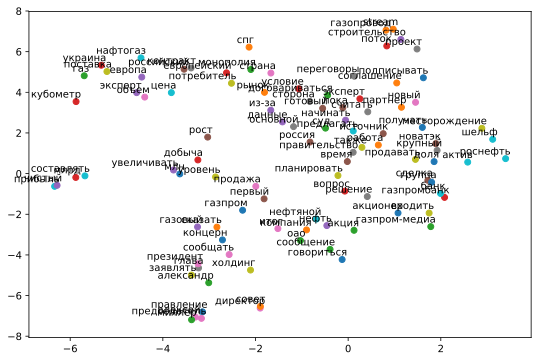

In [43]:
x_axis, y_axis = [], []
for value in top_words_tsne:
    x_axis.append(value[0])
    y_axis.append(value[1])

for i in range(100):
    _ = plt.scatter(x_axis[i], y_axis[i])
    _ = plt.annotate(top_words[i], xy=(x_axis[i], y_axis[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom')

#### Поиск скрытых тем

In [44]:
class DTMcorpus(corpora.textcorpus.TextCorpus):
    def get_texts(self):
        return self.input

    def __len__(self):
        return len(self.input)

corpus = DTMcorpus(tokens_train)
corpus_test = DTMcorpus(tokens_test)

INFO:gensim.corpora.textcorpus:Initializing dictionary
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(6369 unique tokens: ['высокопоставленный', 'вылет', 'абк', 'дестабилизация', 'хватать']...) from 901 documents (total 61032 corpus positions)
INFO:gensim.corpora.textcorpus:Initializing dictionary
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(3099 unique tokens: ['офис', 'белоусов', 'армена', 'киринский', 'пятый']...) from 255 documents (total 13647 corpus positions)


In [45]:
time_seq_train, time_seq_test = [], []
date_str = '01.01.2010'
for i in range(6):
    idx_min = datetime.strptime(date_str[:-1] + str(i), '%d.%m.%Y') < X_train.index
    idx_max = datetime.strptime(date_str[:-1] + str(i + 1), '%d.%m.%Y') > X_train.index
    time_seq_train.append(X_train[idx_min & idx_max].shape[0])
    
for i in range(6, 8):
    idx_min = datetime.strptime(date_str[:-1] + str(i), '%d.%m.%Y') < X_test.index
    idx_max = datetime.strptime(date_str[:-1] + str(i + 1), '%d.%m.%Y') > X_test.index
    time_seq_test.append(X_test[idx_min & idx_max].shape[0])

time_seq_train, time_seq_test

([64, 151, 150, 172, 192, 172], [149, 106])

**Примечание**: требуется указать путь к бинарному исполняемому файлу! ([Инструкция](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb))

In [46]:
DTM_PATH = r"./DTM"
NUM_TOPICS = 4

In [47]:
%%time
dtm_model = DtmModel(DTM_PATH, corpus, time_slices=time_seq_train, num_topics=NUM_TOPICS,
                     id2word=corpus.dictionary, initialize_lda=True)

dim_model = DtmModel(DTM_PATH, corpus, time_slices=time_seq_train, num_topics=NUM_TOPICS,
                     id2word=corpus.dictionary, initialize_lda=True, model='fixed')

INFO:gensim.models.wrappers.dtmmodel:serializing temporary corpus to /tmp/b3cf9b_train-mult.dat
INFO:gensim.corpora.bleicorpus:no word id mapping provided; initializing from corpus
INFO:gensim.corpora.bleicorpus:storing corpus in Blei's LDA-C format into /tmp/b3cf9b_train-mult.dat
INFO:gensim.corpora.bleicorpus:saving vocabulary of 6369 words to /tmp/b3cf9b_train-mult.dat.vocab
INFO:gensim.models.wrappers.dtmmodel:training DTM with args --ntopics=4 --model=dtm  --mode=fit --initialize_lda=true --corpus_prefix=/tmp/b3cf9b_train --outname=/tmp/b3cf9b_train_out --alpha=0.01 --lda_max_em_iter=10 --lda_sequence_min_iter=6  --lda_sequence_max_iter=20 --top_chain_var=0.005 --rng_seed=0 
INFO:gensim.models.wrappers.dtmmodel:Running command ['./DTM', '--ntopics=4', '--model=dtm', '--mode=fit', '--initialize_lda=true', '--corpus_prefix=/tmp/b3cf9b_train', '--outname=/tmp/b3cf9b_train_out', '--alpha=0.01', '--lda_max_em_iter=10', '--lda_sequence_min_iter=6', '--lda_sequence_max_iter=20', '--top_c

CPU times: user 4.37 s, sys: 150 ms, total: 4.52 s
Wall time: 2min 6s


In [48]:
%%time
dtm_model_test = DtmModel(DTM_PATH, corpus_test, time_slices=time_seq_test, num_topics=NUM_TOPICS,
                          id2word=corpus_test.dictionary, initialize_lda=True)

dim_model_test = DtmModel(DTM_PATH, corpus_test, time_slices=time_seq_test, num_topics=NUM_TOPICS,
                          id2word=corpus_test.dictionary, initialize_lda=True, model='fixed')

INFO:gensim.models.wrappers.dtmmodel:serializing temporary corpus to /tmp/45847d_train-mult.dat
INFO:gensim.corpora.bleicorpus:no word id mapping provided; initializing from corpus
INFO:gensim.corpora.bleicorpus:storing corpus in Blei's LDA-C format into /tmp/45847d_train-mult.dat
INFO:gensim.corpora.bleicorpus:saving vocabulary of 3099 words to /tmp/45847d_train-mult.dat.vocab
INFO:gensim.models.wrappers.dtmmodel:training DTM with args --ntopics=4 --model=dtm  --mode=fit --initialize_lda=true --corpus_prefix=/tmp/45847d_train --outname=/tmp/45847d_train_out --alpha=0.01 --lda_max_em_iter=10 --lda_sequence_min_iter=6  --lda_sequence_max_iter=20 --top_chain_var=0.005 --rng_seed=0 
INFO:gensim.models.wrappers.dtmmodel:Running command ['./DTM', '--ntopics=4', '--model=dtm', '--mode=fit', '--initialize_lda=true', '--corpus_prefix=/tmp/45847d_train', '--outname=/tmp/45847d_train_out', '--alpha=0.01', '--lda_max_em_iter=10', '--lda_sequence_min_iter=6', '--lda_sequence_max_iter=20', '--top_c

CPU times: user 1.03 s, sys: 90 ms, total: 1.12 s
Wall time: 20.9 s


In [49]:
train_df = pd.DataFrame()
test_df = pd.DataFrame(dtm_model_test.gamma_)

Заимствовано из https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec/notebook.

In [50]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
        of words) into a feature vector. It averages out all the
        word vectors of the sentence_group.
    """
    words = np.concatenate(np.array(sentence_group).reshape(-1, 1))  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [51]:
w2v_features_train = list(map(
    lambda sen_group: get_w2v_features(w2w_model, sen_group), tokens_train
))
w2v_features_test = list(map(
    lambda sen_group: get_w2v_features(w2w_model, sen_group), tokens_test
))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


Обучение модели.

In [52]:
Xtrain = np.c_[dtm_model.gamma_, w2v_features_train]
Xtest = np.c_[dtm_model_test.gamma_, w2v_features_test]

In [53]:
models = {
    RandomForestClassifier(random_state=RANDOM_SEED, class_weight="balanced"): dict(
        n_estimators=np.linspace(100, 2000, 15, dtype=np.int), 
        max_depth=[5, 10, 15, 20]
    ),
    LogisticRegression(random_state=RANDOM_SEED, class_weight="balanced"): dict(
        C=np.logspace(-4, 1, 15)
    )
}

In [158]:
scores_final = []
names_final = []
best_params_final = []
for model, params in models.items():
    name = model.__class__.__name__
    logging.info("Fiting %s", name)
    cvr_grid = RandomizedSearchCV(
        model,
        params,
        n_iter=10,
        scoring="accuracy",
        cv=SKF,
        random_state=RANDOM_SEED,
        return_train_score=True
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        _ = cvr_grid.fit(Xtrain, y_train.ravel())
        y_hat = cvr_grid.predict(Xtest)
    logging.info("Params:\t%s", cvr_grid.best_params_)
    logging.info("Accuracy:\t%s", accuracy_score(y_test, y_hat))
    logging.info("F-score:\t%s", f1_score(y_test, y_hat))
    names_final.append(name)
    scores_final.append(cvr_grid.cv_results_)
    best_params_final.append(cvr_grid.best_params_)

INFO:root:Fiting LogisticRegression
INFO:root:Params:	{'C': 0.0026826957952797272}
INFO:root:Accuracy:	0.525490196078
INFO:root:F-score:	0.536398467433
INFO:root:Fiting RandomForestClassifier
INFO:root:Params:	{'n_estimators': 100, 'max_depth': 20}
INFO:root:Accuracy:	0.494117647059
INFO:root:F-score:	0.41095890411


Модель не дала прироста в качестве.

###  <center> Выводы

Повысить точность модели выше 60% не удалось. С точки зрения игры на бирже, данный результат можно считать неплохим. Пожалуй, можно было ожидать подобных невысоких результатов, если бы при испотзовании такой достаточно простой модели, получалась точность ~80-90% покупка и продажа акций давно перешла в распоряжение ботов.

Строить предположение, основываясь на налиции определённых слов или фамилий в статьях не имеет смысла, так как мы убедились, что изменение цены акци с ними никак даже не коррелирует (и уж тем более не зависит).

В ходе выполнения задания возникли следующие сложности в обработке текстовых данных, а именно:
* данные зашумлены (много не специфичных высокочастотных слов)
* сложно извлекать признаки
* высокая размерность
* множество подходов к предобработке
* и т. д.